In [1]:
%matplotlib notebook

import os
import sys
import math
import random

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.animation as animation
from IPython.display import display, HTML

# Import dependencies and set random seed
seed_value = 5
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

sys.path.insert(0, os.path.abspath('Support'))

from Obstacle import *

# RTT Connect (3 pts)

Taking the code of the standard RRT algorithm as a starting point, you are asked to implement a bi-directionnal tree roadmap planning algorithm (reference pseudocode shown below)

<img src="Support/images/rrt_pseudo.png" width="500">

To do so, complete the ``planning`` method as follows:

1. Sample and add a node ``new_node`` to the start tree (``self.start_node_list``)
2. Check if there is a node in the end tree (``self.end_node_list``) that is at a distance lesser than ``expand_dis`` from ``new_node``. You can use the existing function ``get_nearest_node_index(.)`` to do so.
3. If that is the case, the trees can be connected and a path has been found! To generate the path, add ``new_node`` to the end tree (after checking that there are no collisions) and return the path generated by the ``self.generate_final_course(len(self.start_node_list) - 1, len(self.end_node_list) - 1))``. The path is ready to be displayed.
4. If there is no node in the end tree close to ``new_node``, sample and add a node to the end tree. Repeat steps 1 to 3 until a path is found.

In [2]:
# This is an adapted version of the RRT implementation done by Atsushi Sakai (@Atsushi_twi)

class RRT:
    """
    Class for RRT planning
    """

    class Node:
        """
        RRT Node
        """

        def __init__(self, x, y):
            self.x = x
            self.y = y
            self.path_x = []
            self.path_y = []
            self.parent = None

    def __init__(self, start=np.zeros(2),
                 goal=np.array([120,90]),
                 obstacle_list=None,
                 width = 160,
                 height=100,
                 expand_dis=3.0, 
                 path_resolution=0.5, 
                 max_points=200):
        """
        Setting Parameter
        start:Start Position [x,y]
        goal:Goal Position [x,y]
        obstacle_list: list of obstacle objects
        width, height: search area
        expand_dis: min distance between random node and closest node in rrt to it
        path_resolion: step size to considered when looking for node to expand
        """
        self.start = self.Node(start[0], start[1])
        self.end = self.Node(goal[0], goal[1])
        self.width = width
        self.height = height
        self.expand_dis = expand_dis
        self.path_resolution = path_resolution
        self.max_nodes = max_points
        self.obstacle_list = obstacle_list
        self.start_node_list = [] # Tree from start
        self.end_node_list = [] # Tree from end

        
    def planning(self):
        """
        rrt path planning
        """

        self.start_node_list = [self.start]
        self.end_node_list = [self.end]
        while len(self.start_node_list) + len(self.end_node_list) <= self.max_nodes:
        
            
        # --------------------------------- TO DO -------------------------
            
            # 1. Sample and add a node in the start tree
#             new_node = self.get_random_node()
#             self.start_node_list.append(new_node)
            rnd_node = self.get_random_node()
            expansion_ind = self.get_nearest_node_index(self.start_node_list, rnd_node)
            expansion_node = self.start_node_list[expansion_ind]
            new_node = self.steer(expansion_node, rnd_node, self.expand_dis)
            if self.is_collision_free(new_node):
                self.start_node_list.append(new_node)
    
                # 2. Check whether trees can be connected.
                expansion_ind = self.get_nearest_node_index(self.end_node_list, new_node)
                expansion_node = self.end_node_list[expansion_ind]
                distance, theta =self.calc_distance_and_angle(expansion_node, new_node)

                # 3. If so, add the node that connects the trees and return the path from start to end.
                # To generate a path, call the self.generate_final_course() method with
                # the last indices of the start and end tree as parameters
                if distance < self.expand_dis:
                    self.end_node_list[-1]=expansion_node
                    
                    return self.generate_final_course(len(self.start_node_list) - 1, len(self.end_node_list) - 1)
                # 4. If trees cannot connect, sample and add a node in the end tree
                else:
                    while 1:
                        rnd_node_1 = self.get_random_node()
                        expansion_ind_1 = self.get_nearest_node_index(self.end_node_list, rnd_node_1)
                        expansion_node_1 = self.end_node_list[expansion_ind_1]
                        new_node_1 = self.steer(expansion_node_1, rnd_node_1, self.expand_dis)
                        if self.is_collision_free(new_node_1):
                            self.end_node_list.append(new_node_1)
                            break
        # ---------------------------------------------------------------------
            # break
            
        return None  # cannot find path
    
    
    def steer(self, from_node, to_node, extend_length=float("inf")):
        """
        Given two nodes from_node, to_node, this method returns a node new_node such that new_node 
        is “closer” to to_node than from_node is.
        """
        
        new_node = self.Node(from_node.x, from_node.y)
        d, theta = self.calc_distance_and_angle(new_node, to_node)
        cos_theta, sin_theta = np.cos(theta), np.sin(theta)

        new_node.path_x = [new_node.x]
        new_node.path_y = [new_node.y]

        if extend_length > d:
            extend_length = d

        # How many intermediate positions are considered between from_node and to_node
        n_expand = math.floor(extend_length / self.path_resolution)

        # Compute all intermediate positions
        for _ in range(n_expand):
            new_node.x += self.path_resolution * cos_theta
            new_node.y += self.path_resolution * sin_theta
            new_node.path_x.append(new_node.x)
            new_node.path_y.append(new_node.y)

        d, _ = self.calc_distance_and_angle(new_node, to_node)
        if d <= self.path_resolution:
            new_node.path_x.append(to_node.x)
            new_node.path_y.append(to_node.y)

        new_node.parent = from_node

        return new_node


    def is_collision_free(self, new_node):
        """
        Determine if nearby_node (new_node) is in the collision-free space.
        """
        if new_node is None:
            return True

        points = np.vstack((new_node.path_x, new_node.path_y)).T
        for obs in self.obstacle_list:
            in_collision = obs.is_in_collision_with_points(points)
            if in_collision:
                return False
        
        return True  # safe
        
    
    def generate_final_course(self, start_mid_point, end_mid_point):
        """
        Reconstruct path from start to end node
        """

        # First half
        node = self.start_node_list[start_mid_point]
        path = []
        while node.parent is not None:
            path.append([node.x, node.y])
            node = node.parent
        path.append([node.x, node.y])
        
        # Other half
        node = self.end_node_list[end_mid_point]
        path = path[::-1]
        while node.parent is not None:
            path.append([node.x, node.y])
            node = node.parent
        path.append([node.x, node.y])

        return path

    def calc_dist_to_goal(self, x, y):
        dx = x - self.end.x
        dy = y - self.end.y
        return math.hypot(dx, dy)

    def get_random_node(self):
        x = self.width * np.random.random_sample()
        y = self.height * np.random.random_sample()
        rnd = self.Node(x, y)
        return rnd
    
    def draw_graph(self):
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                             xlim=(0, 16), ylim=(0, 12))
        ax.grid()
                
        ax.plot(self.start.x, self.start.y, "^r", lw=5)
        ax.plot(self.end.x, self.end.y, "^c", lw=5)
        
        for obs in self.obstacle_list:
            if isinstance(obs, Circle):
                cx, cy = obs.center
                self.plot_circle(ax, cx, cy, obs.radius)
            else:
                ox, oy = obs.plot_obstacle()
                ax.scatter(ox, oy, s=7, c='k')
                
        for node in self.start_node_list:
            if node.parent:
                ax.plot(node.path_x, node.path_y, "g.-")
                
        for node in self.end_node_list:
            if node.parent:
                ax.plot(node.path_x, node.path_y, "b.-")
        
        return fig, ax

    @staticmethod
    def get_nearest_node_index(node_list, rnd_node):        
        # Compute Euclidean disteance between rnd_node and all nodes in tree
        # Return index of closest element
        dlist = [(node.x - rnd_node.x) ** 2 + (node.y - rnd_node.y)
                 ** 2 for node in node_list]
        minind = dlist.index(min(dlist))

        return minind

    @staticmethod
    def calc_distance_and_angle(from_node, to_node):
        dx = to_node.x - from_node.x
        dy = to_node.y - from_node.y
        d = math.hypot(dx, dy)
        theta = math.atan2(dy, dx)
        return d, theta        
        
    @staticmethod
    def plot_circle(ax, x, y, size, color="-b"):  # pragma: no cover
        deg = list(range(0, 360, 5))
        deg.append(0)
        xl = [x + size * math.cos(np.deg2rad(d)) for d in deg]
        yl = [y + size * math.sin(np.deg2rad(d)) for d in deg]
        ax.plot(xl, yl, color)


## Test your Implementation

Use the code provided below to visually test your implementation. If your solution is correct you should obtain a path similar to this one


[[ 1.          1.        ]
 [ 1.08031578  2.99838669]
 [ 1.85801858  4.84098767]
 [ 3.67154655  5.68426477]
 [ 5.52764314  4.939345  ]
 [ 7.50508655  5.23887389]
 [ 8.29434268  6.84898187]
 [10.25145126  7.26096004]
 [12.25135711  7.28036612]
 [14.13396593  6.60524833]
 [14.30621916  4.61267993]
 [13.45778035  4.08338644]
 [12.50284094  2.32609002]
 [14.          1.        ]]


<IPython.core.display.Javascript object>


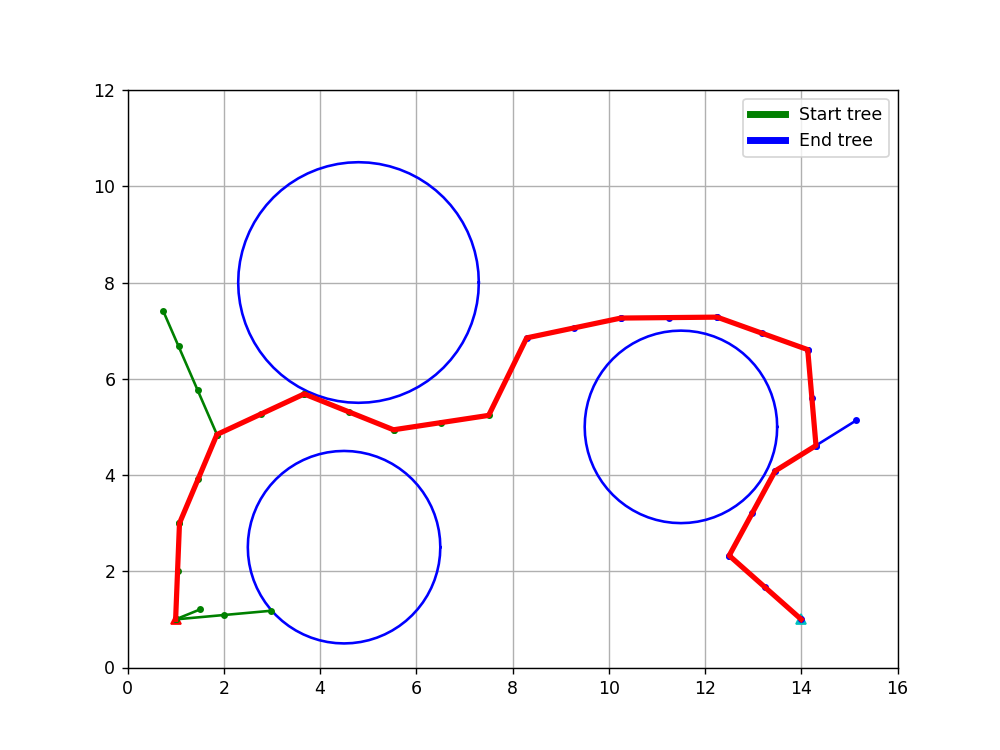

In [23]:
goal = np.array([14.0, 1.0])
start = np.array([1.0, 1.0])

all_obstacles = [Circle(11.5, 5, 2), Circle(4.5, 2.5, 2),
                 Circle(4.8, 8, 2.5)]

rrt = RRT(start=start, goal=goal, width=16, height=10, obstacle_list=all_obstacles,
              expand_dis=2.0, path_resolution=1)

plan = rrt.planning()
plan = np.array(plan)
print(plan)

fig, ax = rrt.draw_graph()
line_path, = ax.plot([], [], "r", lw=3)
custom_lines = [Line2D([0], [0], color='g', lw=4), Line2D([0], [0], color='b', lw=4)]
ax.legend(custom_lines, ['Start tree', 'End tree'])

if np.any(plan):
    start_pos = plan[0,:]
            
    def init():
        line_path.set_data(plan[0], plan[1])
        return line_path

    def animate(i):
        """perform animation step"""
        line_path.set_data(plan[:i,0], plan[:i, 1])
        return line_path

    ani = animation.FuncAnimation(fig, animate, frames=30, repeat=False, interval=100, init_func=init)

## Define a Test Function

This function will be called by the automatic grading tool. **Please do not remove or change it**

In [4]:
def test_rrt(initial_robot_pos=None, goal_pos=None, obstacle_list=None):
    
    # Set parameters is not defined
    if initial_robot_pos is None:
        initial_robot_pos = ([14.0, 1.0])
    
    if start_pos is  None:
        goal_pos = ([1.0, 1.0])
        
    if not obstacle_list:
        obstacle_list = [Circle(11.5, 5, 2), Circle(4.5, 2.5, 2), Circle(4.8, 8, 2.5)]

        obstacle_list = [obstacle1, obstacle2]

    # Run rrt conncect
    rrt = RRT(start=start, goal=goal, width=16, height=10, obstacle_list=obstacle_list,
              expand_dis=2.0, path_resolution=1)
    plan = rrt.planning()
    
    # -------------- Make sure to return the path!!!!---------------
    
    return plan